In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from catboost import CatBoostClassifier

In [21]:
#reading data
train = pd.read_excel("data/Data_Train.xlsx")
test = pd.read_excel("data/Data_Test.xlsx")
submission = pd.read_excel("data/Sample_Submission.xlsx")

In [22]:
print(train.head())

               ID        Date  LicenseNo  FacilityID  FacilityName  \
0  31103489027986  26-04-2010       4744        8123          7715   
1  10088999935915  21-06-2009       2973       12268         11664   
2  40148966010272  01-05-2013      18223        1112           969   
3  37157708563676  28-09-2015      20825       20007         19115   
4  47478049564374  09-12-2015       2136       16867         10409   

            Type  Street         City       State  LocationID  \
0     RESTAURANT   15522  id-11235901  id_1890134     81876.0   
1  GROCERY STORE    3057  id-11235901  id_1890134     81862.0   
2     RESTAURANT   14988  id-11235901  id_1890134     81883.0   
3     RESTAURANT    3661  id-11235901  id_1890134     81859.0   
4     RESTAURANT    7876  id-11235901  id_1890134     81886.0   

                  Reason  SectionViolations RiskLevel     Geo_Loc  \
0                CANVASS               33.0      High  locid16406   
1              COMPLAINT               33.0      H

In [23]:
#split date column in day, month, year
train[['Day','Month','Year']] = train.Date.str.split("-",expand=True)
test[['Day','Month','Year']] = test.Date.str.split("-",expand=True)


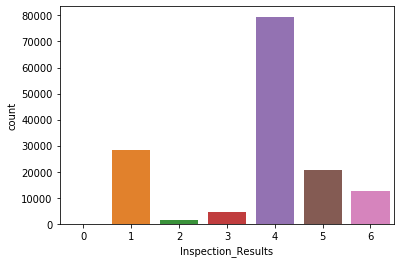

In [24]:
sns.countplot(train.Inspection_Results)

In [25]:
train.Reason.value_counts()

CANVASS                                   77943
LICENSE                                   19645
CANVASS RE-INSPECTION                     15705
COMPLAINT                                 13572
LICENSE RE-INSPECTION                      6796
COMPLAINT RE-INSPECTION                    5655
SHORT FORM COMPLAINT                       5094
SUSPECTED FOOD POISONING                    631
CONSULTATION                                503
TAG REMOVAL                                 456
LICENSE-TASK FORCE                          444
RECENT INSPECTION                           248
OUT OF BUSINESS                             220
TASK FORCE LIQUOR 1475                      187
SUSPECTED FOOD POISONING RE-INSPECTION      147
COMPLAINT-FIRE                              120
SHORT FORM FIRE-COMPLAINT                    77
Name: Reason, dtype: int64

In [26]:
train['SectionViolations'].describe()

count    108375.000000
mean         24.129153
std          12.657456
min           1.000000
25%          14.000000
50%          31.000000
75%          33.000000
max          70.000000
Name: SectionViolations, dtype: float64

In [27]:
#list of missing data columns
missing_cols = [i for i,k in dict(train.isnull().sum()).items() if k > 0]
print(missing_cols)
#new columns 
for col in missing_cols:
    train[col + '_was_missing'] = train[col].isnull()
    test[col + '_was_missing'] = test[col].isnull()

['Type', 'LocationID', 'SectionViolations']


In [28]:
sv_mode_train = train['SectionViolations'].value_counts().index[0]
sv_mode_test = test['SectionViolations'].value_counts().index[0]

print(sv_mode_test, sv_mode_train)

32.0 32.0


In [29]:
#filling missing values
train['SectionViolations'] = train['SectionViolations'].fillna(0)
test['SectionViolations'] = test['SectionViolations'].fillna(0)

train['Type'] = train['Type'].fillna("BLANK")
test['Type'] = test['Type'].fillna("BLANK")

train['LocationID'] =train['LocationID'].fillna(0.0)
test['LocationID'] = test['LocationID'].fillna(0.0)

In [30]:
#categorizing low value counts to others
other_list =(train.Type.value_counts() > 0) & (train.Type.value_counts() < 30)
other_list = (other_list[other_list.values]).index

train_others = [i if i not in other_list else 'other 'for i in train.Type]
test_others = [i if i not in other_list else 'other 'for i in test.Type]

train['Type_New'] = train_others
test['Type_New'] = test_others

In [31]:
#separating features and labels
features = ['LicenseNo','SectionViolations','Geo_Loc','LocationID_was_missing',
            'Type_was_missing','Date',
            'Reason', 'Year','Type','SectionViolations_was_missing']
X = train[features]
y = train.Inspection_Results

In [32]:
#splitting into train and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y)

In [33]:
#list of categorical columns
categorical_features = np.where(X.dtypes =='object')[0]

In [34]:
model_catboost = CatBoostClassifier(
    depth=8, iterations= 250, learning_rate= 0.06)

In [35]:
model_catboost.fit(X,y,cat_features=categorical_features)

0:	learn: 1.7008333	total: 2.1s	remaining: 8m 42s
1:	learn: 1.5309940	total: 4.09s	remaining: 8m 27s
2:	learn: 1.3992025	total: 6.15s	remaining: 8m 26s
3:	learn: 1.2932687	total: 7.98s	remaining: 8m 10s
4:	learn: 1.2008666	total: 10.2s	remaining: 8m 17s
5:	learn: 1.1234931	total: 12.2s	remaining: 8m 15s
6:	learn: 1.0579163	total: 14.3s	remaining: 8m 17s
7:	learn: 1.0011230	total: 16.3s	remaining: 8m 12s
8:	learn: 0.9503972	total: 18.4s	remaining: 8m 13s
9:	learn: 0.9062562	total: 20.8s	remaining: 8m 18s
10:	learn: 0.8656853	total: 22.9s	remaining: 8m 17s
11:	learn: 0.8295685	total: 25.1s	remaining: 8m 18s
12:	learn: 0.7967613	total: 27.4s	remaining: 8m 19s
13:	learn: 0.7673257	total: 29.4s	remaining: 8m 15s
14:	learn: 0.7404659	total: 31.6s	remaining: 8m 15s
15:	learn: 0.7155311	total: 34.1s	remaining: 8m 18s
16:	learn: 0.6922760	total: 36.5s	remaining: 8m 19s
17:	learn: 0.6713098	total: 38.4s	remaining: 8m 15s
18:	learn: 0.6516911	total: 40.7s	remaining: 8m 14s
19:	learn: 0.6336769	to

In [36]:
predicted_y = model_catboost.predict_proba(test[features])

In [48]:
df = pd.DataFrame(data = predicted_y, columns = list(submission.columns))
print(df.head())

   FACILITY CHANGED      FAIL  FURTHER INSPECTION REQUIRED  \
0          0.000117  0.964726                     0.000447   
1          0.000099  0.011888                     0.000214   
2          0.000339  0.005653                     0.001760   
3          0.002606  0.050248                     0.001082   
4          0.000021  0.003390                     0.000086   

   INSPECTION OVERRULED      PASS  PASS(CONDITIONAL)  SHUT-DOWN  
0              0.000767  0.001673           0.031699   0.000571  
1              0.000912  0.983284           0.003182   0.000421  
2              0.854253  0.022696           0.000647   0.114653  
3              0.030395  0.557305           0.003447   0.354918  
4              0.000549  0.991894           0.003853   0.000208  


In [49]:
df.to_excel(r'submission.xlsx', index = None)